Καμάρης Άγγελος
sdi1900070

**Τεχνητή Νοημοσύνη ΙΙ**

(ακαδ. έτος 2022-23)

In [ ]:
#headers used throughout the programm
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from gensim.scripts.glove2word2vec import glove2word2vec


from gensim.models import KeyedVectors
import warnings

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


--2023-01-27 12:58:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-27 12:58:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-27 12:58:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
file=open('/content/drive/MyDrive/imdb-reviews.csv','r', encoding="utf-8")

df= pd.read_csv(file, sep='\t' , on_bad_lines='skip')       #open the file stored in the drive and seperate it by tabs
test_df = None

#test_df=pd.read_csv("file name", sep='\t' , on_bad_lines='skip')   #you can use this to create a test dataframe, but you must enter the filename of the variable that holds the file.

print(df)

df.describe()

                                                    url  rating  \
0      http://www.imdb.com/title/tt0120623/usercomments    10.0   
1      http://www.imdb.com/title/tt0043117/usercomments     9.0   
2      http://www.imdb.com/title/tt0043117/usercomments    10.0   
3      http://www.imdb.com/title/tt0835204/usercomments     4.0   
4      http://www.imdb.com/title/tt0499603/usercomments    10.0   
...                                                 ...     ...   
45003  http://www.imdb.com/title/tt0449000/usercomments     1.0   
45004  http://www.imdb.com/title/tt0109382/usercomments     1.0   
45005  http://www.imdb.com/title/tt0375560/usercomments     1.0   
45006  http://www.imdb.com/title/tt0165107/usercomments     1.0   
45007  http://www.imdb.com/title/tt0041513/usercomments    10.0   

                                                  review  
0      I thought this was a quiet good movie. It was ...  
1      Wagon Master is a very unique film amongst Joh...  
2      This film h

,rating
count,45008.000000
mean,5.481914
std,3.494293
min,1.000000
25%,2.000000
50%,7.000000
75%,9.000000
max,10.000000


In [ ]:



def preprocess(df):       #This function 


  df['review'] = df['review'].astype(str).str.lower()     #make everything lowercase
  regexp = RegexpTokenizer('\w+')
  df['review']=df['review'].apply(regexp.tokenize)        #tokenize the reviews from strings to lists of words


  bigwords = df['review'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))      #keep only words that contain more that 2 letters

  all_words = ' '.join([word for word in bigwords])      #merge them and tokenize them again to create a frequency dictionary
  tw = nltk.tokenize.word_tokenize(all_words)

  fdist = FreqDist(tw)


  df['review'] = df['review'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))  #remove not frequent words


  lem = WordNetLemmatizer()

  df['review'] = df['review'].apply(lem.lemmatize)                  #lematize



  
preprocess(df)

if test_df != None:                     #if a testset is given, preprocess it
  preprocess(test_df)

In [ ]:
X=df.drop('rating', axis=1)
X=df.drop('url', axis=1)
Y = df[['rating']] # [[ ]] used to keep the label
Y.loc[Y['rating'] <= 4, 'rating'] = 0                 #keep only valuable data, for X and Y
Y.loc[Y['rating'] >= 7, 'rating'] = 1


if test_df == None:
  X_train_unvect, X_test_unvect, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)              #if we are not given a test set, we will split our current data.
else:
  X_train_unvect = X
  Y_train = Y
  X_test_unvect = test_df.drop('rating', axis=1)
  X_test_unvect = test_df.drop('url', axis=1)
  Y_test = test_df[['rating']] # [[ ]] used to keep the label

  Y_test.loc[Y_test['rating'] <= 4, 'rating'] = 0
  Y_test.loc[Y_test['rating'] >= 7, 'rating'] = 1


glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'


glove2word2vec(glove_input_file, w2v_output_file)


data=X_train_unvect['review']
data2=X_test_unvect['review']



model = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

warnings.simplefilter(action='ignore', category=FutureWarning)

X_train=[]
X_test=[]

temp=0
for row in data.str.split():
  sum=0;
  c=0;
  for w in row:
    if w in model.vocab:
      sum+=model[w]
      temp=model[w]
      c+=1
  X_train.append(sum/c)

temp=0
for row in data2.str.split():
  sum=0;
  c=0;
  for w in row:
    if w in model.vocab:
      sum+=model[w]
      temp=model[w]
      c+=1
  X_test.append(sum/c)



/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
X_train_tor=torch.tensor(np.array(X_train), dtype=torch.float)
X_test_tor=torch.tensor(np.array(X_test), dtype=torch.float)
Y_train_tor=torch.tensor(np.array(Y_train), dtype=torch.long)
Y_test_tor=torch.tensor(np.array(Y_test), dtype=torch.float)


print(f"x train shape: {X_train_tor.shape}")
print(f"x test shape: {X_test_tor.shape}")
print(f"y train shape: {Y_train_tor.shape}")
print(f"y test shape: {Y_test_tor.shape}")

x train shape: torch.Size([31505, 300])
x test shape: torch.Size([13503, 300])
y train shape: torch.Size([31505, 1])
y test shape: torch.Size([13503, 1])


In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys
from IPython.display import Image

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
        This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = 'cpu'
print('Working on:', device)

Working on: cpu


In [78]:
class RNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, layers_size, output_size,clip,  p):
        super(RNN, self).__init__()
        cells = {
        "RNN" : nn.RNN,
        "LSTM"    : nn.LSTM,
        "GRU"     : nn.GRU
        }
        self.cell_type = cell_type
        self.rnn = cells[cell_type](input_size, hidden_size, layers_size, batch_first=True, bidirectional=True)
        self.out = nn.Linear(hidden_size*3, output_size)
        self.clip = clip
        self.dropout = nn.Dropout(p)
        self.attention_weight = nn.Parameter(torch.randn(hidden_size*2))
        

    def forward(self, x):
        if self.cell_type == 'LSTM':
            out, (h_n, h_c) = self.rnn(x) 
        else:
            out, h_n = self.rnn(x)
        out = self.dropout(out)
        attn_scores = torch.sum(out * self.attention_weight, dim=2)
        attn_scores = attn_scores.softmax(dim=1)
        attn_applied = torch.einsum("ij,ijk->ik", attn_scores, out)
        out = torch.cat([x[:, -1, :], attn_applied], dim=-1)
        out = self.dropout(out)
        out = self.out(out)
        return out


    def backward(self, loss):
        loss.backward()
        nn.utils.clip_grad_norm_(self.parameters(), self.clip)


In [79]:
cell_type = 'GRU'
input_size = 300
hidden_size = 300
layers_size = 1
output_size = 2
clip=10
p=0.5

EPOCH = 100
LR = 1e-3

# Initialize the model
net = RNN(cell_type,input_size, hidden_size, layers_size, output_size,clip,p)

optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters
loss_func = nn.CrossEntropyLoss()

Epoch   0: Loss = 0.46058
Epoch   1: Loss = 0.40544
Epoch   2: Loss = 0.39816
Epoch   3: Loss = 0.39228
Epoch   4: Loss = 0.39104
Epoch   5: Loss = 0.38732
Epoch   6: Loss = 0.38492
Epoch   7: Loss = 0.38300
Epoch   8: Loss = 0.38125
Epoch   9: Loss = 0.38006
Epoch  10: Loss = 0.37807
Epoch  11: Loss = 0.37692
Epoch  12: Loss = 0.37574
Epoch  13: Loss = 0.37470
Epoch  14: Loss = 0.37431
Epoch  15: Loss = 0.37257
Epoch  16: Loss = 0.37114
Epoch  17: Loss = 0.36934
Epoch  18: Loss = 0.36880
Epoch  19: Loss = 0.36763
Epoch  20: Loss = 0.36611
Epoch  21: Loss = 0.36344
Epoch  22: Loss = 0.36417
Epoch  23: Loss = 0.36235
Epoch  24: Loss = 0.36371
Epoch  25: Loss = 0.36132
Epoch  26: Loss = 0.36041
Epoch  27: Loss = 0.36002
Epoch  28: Loss = 0.35850
Epoch  29: Loss = 0.35827
Epoch  30: Loss = 0.35561
Epoch  31: Loss = 0.35650
Epoch  32: Loss = 0.35497
Epoch  33: Loss = 0.35531
Epoch  34: Loss = 0.35285
Epoch  35: Loss = 0.35407
Epoch  36: Loss = 0.35195
Epoch  37: Loss = 0.35165
Epoch  38: L

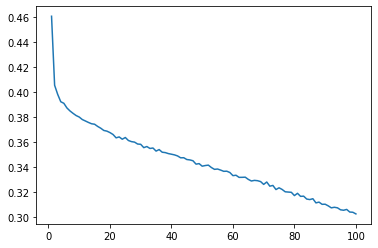

In [80]:
dataset = torch.utils.data.TensorDataset(X_train_tor, Y_train_tor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=False)


# Start train mode
net.train()

losses=[]
for epoch in range(EPOCH):
  batch_losses = 0.0

  for x_batch, y_batch in dataloader:
    # print(x_batch)
    # print(y_batch)
    x=x_batch.view(-1, 1, 300)
    y_pred = net(x)
    y=y_batch.view(-1)
    # print(x)
    # print(y)
    # print(y_pred)
    loss = loss_func(y_pred, y)
    batch_losses+=loss.item()
    
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
  losses.append(batch_losses/len(dataloader))
  # print(pred_y)
  # print(Y_test_tor)
  print(f"Epoch {epoch:3}: Loss = {batch_losses/len(dataloader):.5f}")

plt.plot(list(range(1,EPOCH+1)),losses)


In [81]:
from sklearn.metrics import accuracy_score
net.eval();
test_output = net(X_test_tor.view(-1, 1, 300))
pred_y = test_output.view(-1,2)
pred_y = pred_y.argmax(dim=1)
y=Y_test_tor
accuracy_score(y,pred_y)

0.8540324372361697

F1 Score Train: 0.8380355276907001
F1 Score Validation: 0.8540129521205184
F1 Score Train: 0.8812050986767381
F1 Score Validation: 0.8540129521205184
F1 Score Train: 0.8826563200907087
F1 Score Validation: 0.8540129521205184
F1 Score Train: 0.8716445314086171
F1 Score Validation: 0.8540129521205184
F1 Score Train: 0.8814793687307086
F1 Score Validation: 0.8540129521205184
F1 Score Train: 0.8813626100986403
F1 Score Validation: 0.8540129521205184
F1 Score Train: 0.8783796283042136
F1 Score Validation: 0.8540129521205184
F1 Score Train: 0.8808869131871407
F1 Score Validation: 0.8540129521205184
F1 Score Train: 0.8811407695809461
F1 Score Validation: 0.8540129521205184
F1 Score Train: 0.880017804733908
F1 Score Validation: 0.8540129521205184


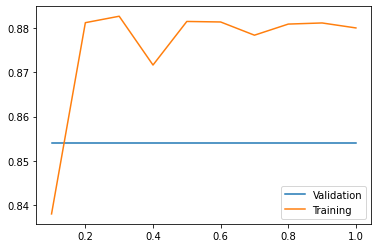

In [82]:
list_f1=[]
list_f1_train=[]
list_sample_size=[]

for times in range(10):
  # training
  #
  X, X_unused, y, y_unused = train_test_split(X_train_tor, Y_train_tor, test_size=1 - (times * 0.1 + 0.001))


  results_train = net(X.view(-1,1,300)).view(-1,2).argmax(dim=1)

  # validation
  # 
  results = net(X_test_tor.view(-1,1,300)).view(-1,2).argmax(dim=1)
  

  # score
  #
  f1_train = f1_score(np.array(y.detach().numpy()),results_train.detach().numpy(), average='macro')
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(Y_test, results.detach().numpy(), average='macro')
  print("F1 Score Validation: " + str(f1))

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

# print(plot_data)
plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)


plt.legend(["Validation", "Training"])

In [83]:
predictions_train = net(X_train_tor.view(-1,1,300)).view(-1,2).argmax(dim=1)
predictions_val = net(X_test_tor.view(-1,1,300)).view(-1,2).argmax(dim=1)


# F-Score

f1_train = f1_score(Y_train, predictions_train)
f1_val = f1_score(Y_test, predictions_val)

print("F1 Score (train):", f1_train)
print("F1 Score (validation):", f1_val)

# Recall

r_train = recall_score(Y_train, predictions_train)
r_val = recall_score(Y_test, predictions_val)

print("Recall Score (train):", r_train)
print("Recall Score (validation):", r_val)

# Prediction score

p_train = precision_score(Y_train, predictions_train)
p_val = precision_score(Y_test, predictions_val)

print("Precision Score (train):", p_train)
print("Precision Score (validation):", p_val)

F1 Score (train): 0.8789439793947199
F1 Score (validation): 0.8523263654753878
Recall Score (train): 0.8674928503336511
Recall Score (validation): 0.83980510851912
Precision Score (train): 0.8907014681892332
Precision Score (validation): 0.8652266504411318


In [84]:
PATH='gru_NN.pt'
torch.save(net.state_dict(), PATH)
model = RNN(cell_type,input_size, hidden_size, layers_size, output_size,clip,p)
model.load_state_dict(torch.load(PATH))
model.eval()

RNN(
  (rnn): GRU(300, 300, batch_first=True, bidirectional=True)
  (out): Linear(in_features=900, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)